## Vehicle Detection Project
The goals / steps of this project are the following project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test\_video.mp4 and later implement on full project\_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Histogram of Oriented Gradients (HOG)
* Read vehicle and non-vehicle images
* Show each examle of image
* Extract HOG features using YCrCb color space and HOG parameters and show the examples of output

In [67]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

orient = 8
pix_per_cell = 8
cell_per_block = 2

Number of car images:  8792
Number of non-car images:  3900


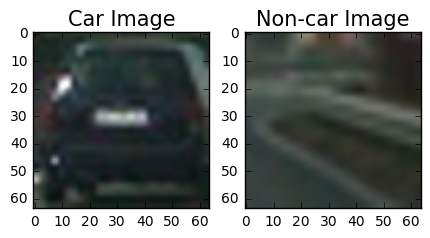

In [62]:
car_files = glob.glob('/home/kazuhiro/TrainingImage_UDACITY/vehicles/*/*.png')
noncar_files = glob.glob('/home/kazuhiro/TrainingImage_UDACITY/non-vehicles/GTI/image*.png')

print("Number of car images: ",len(car_files))
print("Number of non-car images: ",len(noncar_files))

img_car = mpimg.imread(car_files[0])
img_noncar = mpimg.imread(noncar_files[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5))
ax1.imshow(img_car)
ax1.set_title('Car Image',fontsize=15)
ax2.imshow(img_noncar)
ax2.set_title('Non-car Image', fontsize=15)

Here is an example using the YCrCb color space and HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):

In [63]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


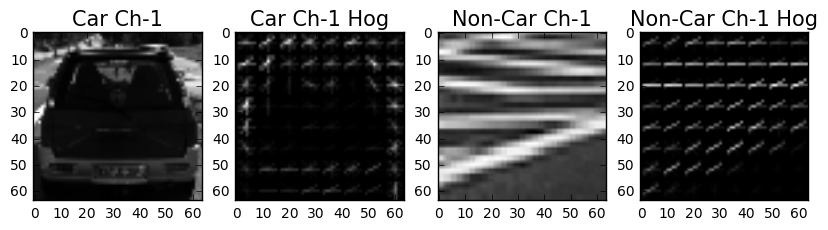

In [64]:
orient = 8
pix_per_cell = 8
cell_per_block = 2

caridx = np.random.randint(0,len(car_files)-1)
noncaridx = np.random.randint(0,len(noncar_files)-1)

carimg = mpimg.imread(car_files[caridx])
carimg = cv2.cvtColor(carimg, cv2.COLOR_RGB2YCrCb)

car_ch1 = carimg[:,:,0]
car_ch2 = carimg[:,:,1]
car_ch3 = carimg[:,:,2]

hog_feat1, hog_img1 = get_hog_features(car_ch1, orient, pix_per_cell, cell_per_block, vis=True)
hog_feat2, hog_img2 = get_hog_features(car_ch2, orient, pix_per_cell, cell_per_block, vis=True)
hog_feat3, hog_img3 = get_hog_features(car_ch3, orient, pix_per_cell, cell_per_block, vis=True)

noncarimg = mpimg.imread(noncar_files[noncaridx])
noncarimg = cv2.cvtColor(noncarimg, cv2.COLOR_RGB2YCrCb)

noncar_ch1 = noncarimg[:,:,0]
noncar_ch2 = noncarimg[:,:,1]
noncar_ch3 = noncarimg[:,:,2]

noncar_hog_feat1, noncar_hog_img1 = get_hog_features(noncar_ch1, orient, pix_per_cell, cell_per_block, vis=True)
noncar_hog_feat2, noncar_hog_img2 = get_hog_features(noncar_ch1, orient, pix_per_cell, cell_per_block, vis=True)
noncar_hog_feat3, noncar_hog_img3 = get_hog_features(noncar_ch1, orient, pix_per_cell, cell_per_block, vis=True)


f, ((ax1, ax2,ax3, ax4)) = plt.subplots(1,4,figsize=(10,5))
ax1.imshow(car_ch1,cmap='gray')
ax1.set_title('Car Ch-1',fontsize=15)
ax2.imshow(hog_img1,cmap='gray')
ax2.set_title('Car Ch-1 Hog',fontsize=15)
ax3.imshow(noncar_ch1,cmap='gray')
ax3.set_title('Non-Car Ch-1',fontsize=15)
ax4.imshow(noncar_hog_img1,cmap='gray')
ax4.set_title('Non-Car Ch-1 Hog',fontsize=15)